In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from KMeansMissing import kmeans_missing

In [2]:
sacog_wDemo = pd.read_csv('../data/manipulatedData/rMoves_and_2020_matchLabel.csv')
sacog_wDemo = sacog_wDemo.iloc[2838:,:]
sacog = pd.read_excel('../data/manipulatedData/sacog_with_new_variables.xlsx')
sacog = sacog[sacog.iloc[:,0].isin(sacog_wDemo.match_id)]

In [3]:
# Filter out demo of interest
demo = ['match_id', 
        'PersonalIncome', 
        'Children-12To18', 'Children-5To12', 'Children-Under5',
        'What is your age group?',
        'HouseholdIncome', 
        'Gender',
#        'May-Employment', 'May-Employment-Industry', 
#         'ethnicity_afam',
#         'ethnicity_aiak',
#         'ethnicity_asian',
#         'ethnicity_hapi',
#         'ethnicity_hisp',
#         'ethnicity_mideast',
#         'ethnicity_multi',
#         'ethnicity_noanswer',
#         'ethnicity_other',
#         'ethnicity_white',
#         'Disability-Chronic',
#         'Disability-Developmental',
#         'Disability-Hearing',
#         'Disability-MentalHealth',
#         'Disability-None',
#         'Disability-Other',
#         'Disability-Physical',
#         'Disability-Vision',
        'hhveh',
        'numkids']
sacog_wDemo = sacog_wDemo[demo]

In [12]:
# Data manipulation

# change data type
changeType = ['match_id', 'Children-12To18', 'Children-5To12', 'Children-Under5', 
#            'Disability-Chronic',
#            'Disability-Developmental',
#            'Disability-Hearing',
#            'Disability-MentalHealth',
#            'Disability-None',
#            'Disability-Other',
#            'Disability-Physical',
#            'Disability-Vision'
             ] 
sacog_wDemo[changeType] = sacog_wDemo[changeType].astype('int64')


sacog_wDemo.rename(columns = {'What is your age group?': 'age'}, inplace = True)

sacog_wDemo[['Children-12To18', 'Children-5To12', 'Children-Under5']] = sacog_wDemo[['Children-12To18', 'Children-5To12', 'Children-Under5']].replace(-9998, 0)
sacog_wDemo['kids'] = np.sum(sacog_wDemo[['Children-12To18', 'Children-5To12', 'Children-Under5']], axis =1)

In [14]:
sacog_demo = pd.merge(sacog_wDemo, sacog, left_on = 'match_id', right_on = 'id')

In [15]:
# Infer income and age category

def incomeLevel(income):
    if income in ['Under $10,000', '$10,000 - $14,999','$15,000 - $24,999','$25,000 - $49,999']:
        return 'Low income'
    elif income in ['$50,000 - $74,999', '$75,000 - $99,999']:
        return 'Medium income'
    elif income in ['$100,000 - $149,999', '$150,000 - $199,999','$200,000 or more']: 
        return 'High income'
    else:
        return 'Unknown'
    
sacog_demo.loc[sacog_demo.NumberInHousehold == 1, 'HouseholdIncome'] = sacog_demo.loc[sacog_demo.NumberInHousehold == 1, 'PersonalIncome']
sacog_demo['incomelevel'] = sacog_demo['HouseholdIncome'].apply(incomeLevel)

def ageLevel(age):
    if age in ['18 - 19', '20 - 24', '25 - 34', '35 - 44']:
        return 'Gen Y & Z'
    elif age in ['45 - 54']:
        return 'Gen X'
    elif age in ['55 - 59', '60 - 64', '65 - 74', '75 - 84']:
        return 'Baby Boomer and Older'
    
sacog_demo['ageLevel'] = sacog_demo['age'].apply(ageLevel)

In [17]:
sacog_demo.to_csv('../data/manipulatedData/sacog_for_final_analysis.csv')

In [4]:
sacog_demo = pd.read_csv('../data/manipulatedData/sacog_for_final_analysis.csv')
cat = ['ChildcareItems', 'Clothing', 'Medication', 'HomeOffice', 'PreparedFood', 'OtherFood', 'PaperCleaning', 'Groceries' ]

# Find all the observations with complete shopping records for centroid initialization
subset = sacog_demo[~sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]].isna().any(axis = 1)]
subset = subset[['May-Portion-E'+cat_ for cat_ in cat]]

# X is for clustering, contain all 313 records, with nan representing 'no shopping'
X = sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]]

In [15]:
# Weighting means I care more about the similarity or dissimilarity of purchase channel for 
# categories with a higher weight. Categories with a higher shopping rate will get a higher weight
K = range(2, 15)
cost = []
sil = []

# The weight is calculated using the inverse of shopping rate for each category and normalized by the lowest weight - childcareItem
# The weight for grocery is set to 10
weight = np.array(1/(sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]].isna().sum() / 313)) 
weight = weight/weight[0]
#weight[-1] = 10

for i in K:
    km = kmeans_missing(potential_centroids = subset, n_clusters = i, weight = weight)
    km.fit(X, max_iter = 10000, number_of_runs = 1000, init = 'random')
    cost.append(km.costs)
    sil.append(km.silhouette(X))

D:\Moomoo Research\ECommerce study\script\KMeansMissing.py:134: RuntimeWarning: invalid value encountered in double_scalars
  sil_.append((b - a)/max(a,b))
D:\Moomoo Research\ECommerce study\script\KMeansMissing.py:88: RuntimeWarning: Mean of empty slice
  centroids[j] = np.nanmean(data[clusters == j], axis = 0)


Text(0.5, 1.0, 'Silhouette score')

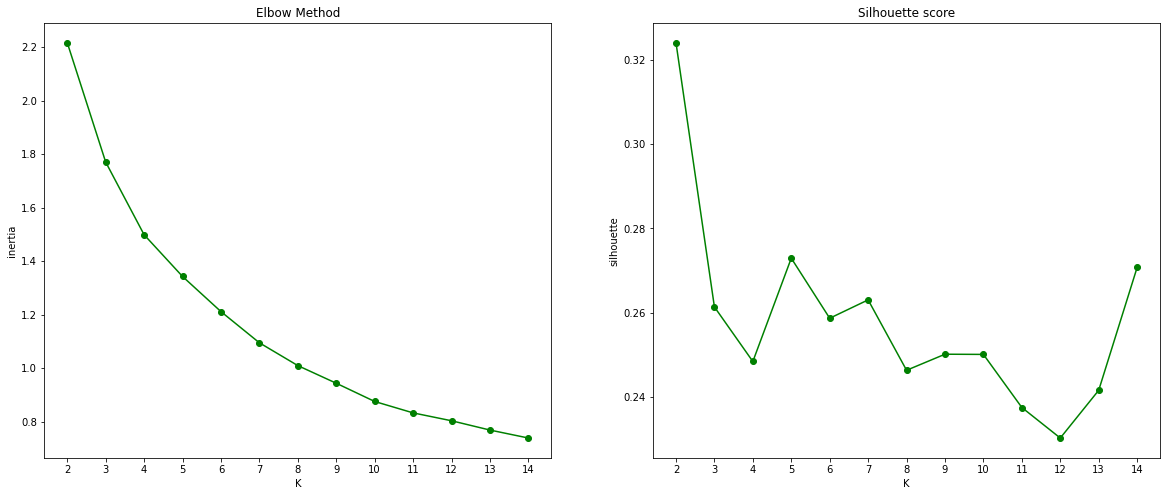

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
ax[0].plot(K, cost, 'go-')
ax[0].set_xlabel('K')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(K)
ax[0].set_title('Elbow Method')

ax[1].plot(K, sil, 'go-')
ax[1].set_xlabel('K')
ax[1].set_ylabel('silhouette')
ax[1].set_xticks(K)
ax[1].set_title('Silhouette score')

In [17]:
import random
random.seed(310)
km5 = kmeans_missing(subset, 5, weight = weight) 
km5.fit(X, max_iter = 10000, number_of_runs = 10000, init = 'random')

In [18]:

df = pd.DataFrame(km5.centroids, columns = cat)
df
df['size'] = np.unique(km5.labels, return_counts = True)[1]
df['Percentage'] = df['size']/313
group = ['ENonFood & EPrepFood', 'ENonFood','ECommerce Dependent','Partially ECommerce','ECommerce Independent', ]
#df.set_index(pd.Index(group), inplace = True)
#df = df.loc[['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent']]
df.style.background_gradient(subset = cat)


,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries,size,Percentage
0,0.777778,0.787500,0.792063,0.516667,0.033188,0.103704,0.063248,0.017000,51,0.162939
1,0.596647,0.602739,0.382270,0.442593,0.426452,0.424249,0.318651,0.435764,59,0.188498
2,0.816691,0.855067,0.758563,0.758170,0.651797,0.712500,0.776860,0.828755,28,0.089457
3,0.317949,0.126263,0.144608,0.139535,0.259557,0.059829,0.022078,0.004021,96,0.306709
4,0.634503,0.641531,0.400955,0.572042,0.587659,0.286275,0.327790,0.040784,79,0.252396


In [248]:
past_percentage = sacog_demo['past_label'].value_counts(normalize=True).values

In [249]:
df = pd.DataFrame({'Pre-pandemic': np.dot(np.array(df[cat]).T, past_percentage),
              'During': sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]].mean().values})


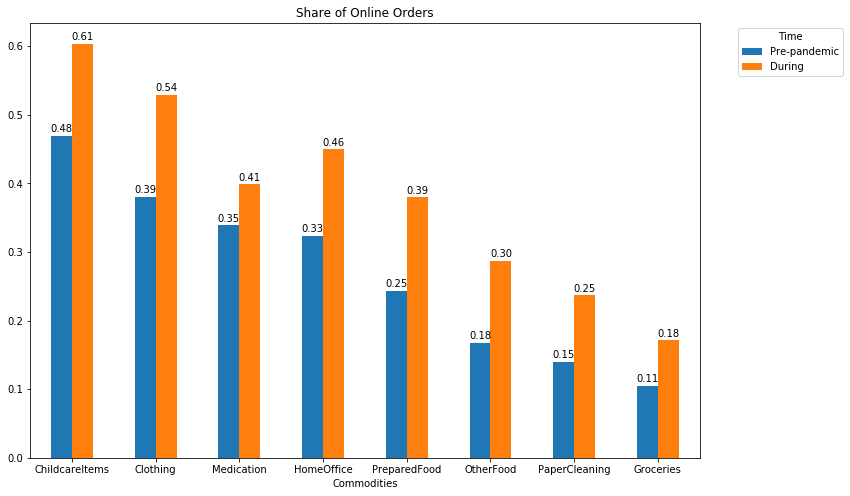

In [257]:
plt.figure(figsize=(12, 8))
df.rename(dict(zip(range(8), cat))).plot(kind = 'bar', ax = plt.gca())
plt.xticks(rotation = 0)
plt.gca().legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Share of Online Orders')
plt.xlabel('Commodities')

for rect in plt.gca().patches:
    # Find where everything is located
        height = rect.get_height() + 0.01
        width = rect.get_width()
        x = rect.get_x()       
        label_x = x + width/2 
 

    # plot only when height is greater than specified value
        if height > 0:
            plt.gca().text(label_x, height, f'{height:.2f}', ha='center', va='center', fontsize=10)

In [22]:
dict_ = dict(zip(range(5), group))
sacog_demo['labels5'] = km5.labels
sacog_demo['labels5'] = sacog_demo.labels5.map(dict_)

### HETEROGENEITY IN DEMOGRAPHICS

In [24]:
sacog_demo.groupby('labels5')['ageLevel'].value_counts(normalize=True).unstack()

ageLevel,Baby Boomer and Older,Gen X,Gen Y & Z
labels5,,,
ECommerce Dependent,0.551724,0.172414,0.275862
ECommerce Independent,0.469880,0.120482,0.409639
ENonFood,0.491228,0.192982,0.315789
ENonFood & EPrepFood,0.336957,0.206522,0.456522
Partially ECommerce,0.403846,0.173077,0.423077


In [25]:
sacog_demo.groupby('labels5')['incomelevel'].value_counts(normalize=True).unstack()

incomelevel,High income,Low income,Medium income,Unknown
labels5,,,,
ECommerce Dependent,0.344828,0.206897,0.413793,0.034483
ECommerce Independent,0.397590,0.204819,0.313253,0.084337
ENonFood,0.473684,0.192982,0.210526,0.122807
ENonFood & EPrepFood,0.554348,0.108696,0.260870,0.076087
Partially ECommerce,0.423077,0.057692,0.269231,0.250000


In [26]:
sacog_demo.groupby('labels5')['kids'].value_counts(normalize=True).unstack()

kids,0,1,2,3,4
labels5,,,,,
ECommerce Dependent,0.689655,0.137931,0.103448,0.068966,NaN
ECommerce Independent,0.771084,0.084337,0.120482,0.024096,NaN
ENonFood,0.859649,0.087719,0.052632,NaN,NaN
ENonFood & EPrepFood,0.771739,0.097826,0.097826,0.021739,0.010870
Partially ECommerce,0.730769,0.115385,0.096154,0.038462,0.019231


In [27]:
sacog_demo.groupby('labels5')['hhveh'].value_counts(normalize=True).unstack()

hhveh,0,1,2,3,4,5,8
labels5,,,,,,,
ECommerce Dependent,0.137931,0.172414,0.482759,0.172414,0.034483,NaN,NaN
ECommerce Independent,0.024096,0.397590,0.469880,0.084337,0.024096,NaN,NaN
ENonFood,0.017544,0.456140,0.350877,0.122807,0.035088,NaN,0.017544
ENonFood & EPrepFood,0.043478,0.369565,0.434783,0.076087,0.054348,0.021739,NaN
Partially ECommerce,0.057692,0.346154,0.365385,0.134615,0.076923,0.019231,NaN


### FUTURE INTENTION

In [28]:
sacog_demo[sacog_demo != -9998].groupby('labels5')[['DoInStage23-ContactlessDoor',
 
 'DoInStage23-CurbsidePickup',
 'DoInStage23-InStorePickup',
 
 
 'DoInStage23-VisitRetail',
 'DoInStage23-VisitRestaurant',
    'COVID-PPEReducesContraction',
 'COVID-PPEReducesTransmission',
 'COVID-AbleSocialDistance']].mean()

,DoInStage23-ContactlessDoor,DoInStage23-CurbsidePickup,DoInStage23-InStorePickup,DoInStage23-VisitRetail,DoInStage23-VisitRestaurant,COVID-PPEReducesContraction,COVID-PPEReducesTransmission,COVID-AbleSocialDistance
labels5,,,,,,,,
ECommerce Dependent,4.000000,3.344828,2.758621,2.586207,2.379310,3.931034,4.551724,4.310345
ECommerce Independent,3.048780,2.829268,2.975610,3.759036,3.036145,4.000000,4.487805,4.304878
ENonFood,2.736842,2.771930,2.859649,3.561404,2.947368,3.929825,4.350877,4.333333
ENonFood & EPrepFood,3.433333,3.655556,3.566667,3.566667,2.922222,4.065217,4.413043,4.228261
Partially ECommerce,3.865385,3.442308,3.326923,3.153846,2.788462,4.076923,4.576923,4.346154


In [31]:
sum(sacog_demo[sacog_demo.labels5 == 'ENonFood']['DoInStage23-InStorePickup'].value_counts(normalize=True).sort_index()[:2])

0.3684210526315789

In [37]:
sum(sacog_demo[sacog_demo.labels5 == 'ENonFood & EPrepFood']['DoInStage23-CurbsidePickup'].value_counts(normalize=True).sort_index()[4:])

0.5978260869565217

### Problem:
1) The group mean orders are too high for some categories. E.g. food
2) Some household might don't shop for some categories.
### SOLUTION:
1) Set the bar to be lower (replace outliers with 95 percentile)

2) Use the present matrix to see if some (x)

3) Assign labels by hand (x)

####  Method 1 (work not that good, choose method 2 without standardization instead)
Didn't multiply by the growth rate!! Shouldn't!!
Did standardization
The problem of using number of online orders to calculate the distance is we don't know if a category was essential to the household or not in the past year.

In [46]:
X_May = sacog_demo[['May-Orders-'+ cat_ for cat_ in cat]]
X_Past = sacog_demo[['PastYear-Orders-'+cat_ for cat_ in cat]]
#X_Past = X_Past * (np.mean(X_May).values/np.mean(X_Past).values)
X_Past.columns = cat
X_May.columns = cat

In [40]:
X_May.groupby(sacog_demo.labels5).mean()

,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries
labels5,,,,,,,,
ECommerce Dependent,3.172414,3.931034,2.482759,1.827586,6.103448,2.275862,3.862069,7.379310
ECommerce Independent,0.313253,0.180723,0.445783,0.265060,1.228916,0.120482,0.120482,0.120482
ENonFood,0.403509,3.192982,2.070175,0.456140,0.438596,0.192982,0.280702,0.403509
ENonFood & EPrepFood,0.630435,3.228261,1.250000,1.369565,6.141304,0.706522,0.847826,0.336957
Partially ECommerce,0.769231,2.326923,1.788462,0.865385,4.057692,2.134615,1.730769,5.211538


In [41]:
# Don't Run a second time
for cat_ in cat:
    X_May.loc[X_May[cat_] > X_May[cat_].quantile(.90), cat_] = X_May[cat_].quantile(.90)

/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
X_May.groupby(sacog_demo.labels5).mean()

,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries
labels5,,,,,,,,
ECommerce Dependent,0.310345,2.689655,1.931034,1.413793,4.310345,1.931034,2.206897,3.517241
ECommerce Independent,0.060241,0.180723,0.397590,0.216867,1.180723,0.120482,0.120482,0.120482
ENonFood,0.122807,2.631579,1.578947,0.456140,0.438596,0.192982,0.210526,0.403509
ENonFood & EPrepFood,0.184783,2.315217,1.032609,1.021739,5.054348,0.619565,0.695652,0.336957
Partially ECommerce,0.211538,2.096154,1.365385,0.865385,3.403846,1.326923,1.346154,3.826923


In [346]:
for cat_ in cat:
    X_May.loc[X_May[cat_] > X_May[cat_].quantile(.95), cat_] = X_May[cat_].mean()

/Users/apple/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [324]:
X_May.groupby(sacog_demo.labels5).mean()

,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries
labels5,,,,,,,,
ECommerce Dependent,0.965517,2.855172,2.344828,1.413793,5.000000,1.931034,2.206897,5.310345
ECommerce Independent,0.216867,0.180723,0.445783,0.216867,1.228916,0.120482,0.120482,0.120482
ENonFood,0.333333,2.743860,2.000000,0.456140,0.438596,0.192982,0.210526,0.403509
ENonFood & EPrepFood,0.413043,2.436957,1.250000,1.021739,5.619565,0.619565,0.695652,0.336957
Partially ECommerce,0.461538,2.157692,1.673077,0.865385,3.750000,1.326923,1.346154,4.750000


In [43]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_May)
X_May_scaled = scaler.transform(X_May)
X_Past_scaled = pd.DataFrame(scaler.transform(X_Past))
mean_ = pd.DataFrame(X_May_scaled).groupby(sacog_demo.labels5).mean()

In [44]:
def past_year(row):
    idx = row.name
    if sacog_demo.iloc[idx]['numkids'] == 0:
        return np.sum((row[1:] - mean_[[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
    else:
        return np.sum((row-mean_)**2, axis = 1).idxmin()

In [52]:
def past_year_essential(row):
    idx = row.name
    if sacog_demo.iloc[idx]['numkids'] == 0:
        return np.sum((row[1:] - mean_[[1,2,4,6,7]])**2, axis = 1).idxmin()
    else:
        return np.sum((row-mean_[[0,1,2,4,6,7]])**2, axis = 1).idxmin()

In [45]:
# scaled
past_label = X_Past_scaled.apply(lambda x: past_year(x), axis = 1)
ct = pd.crosstab(past_label, sacog_demo.labels5, margins = True)[['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All']]
ct = ct.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All'])
ct

labels5,ECommerce Independent,ENonFood,ENonFood & EPrepFood,Partially ECommerce,ECommerce Dependent,All
row_0,,,,,,
ECommerce Independent,56,37,46,26,11,176
ENonFood,9,9,14,12,2,46
ENonFood & EPrepFood,5,4,15,5,4,33
Partially ECommerce,7,5,11,5,6,34
ECommerce Dependent,6,2,6,4,6,24
All,83,57,92,52,29,313


In [53]:
past_label = X_Past_scaled.apply(lambda x: past_year_essential(x), axis = 1)
ct = pd.crosstab(past_label, sacog_demo.labels5, margins = True)[['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All']]
ct = ct.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All'])
ct

labels5,ECommerce Independent,ENonFood,ENonFood & EPrepFood,Partially ECommerce,ECommerce Dependent,All
row_0,,,,,,
ECommerce Independent,60,41,50,29,11,191
ENonFood,6,6,11,11,3,37
ENonFood & EPrepFood,5,3,16,3,2,29
Partially ECommerce,7,4,10,5,5,31
ECommerce Dependent,5,3,5,4,8,25
All,83,57,92,52,29,313


In [294]:
past_label = X_Past_scaled.apply(lambda x: past_year(x), axis = 1)
ct = pd.crosstab(past_label, sacog_demo.labels5, margins = True)[['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All']]
ct = ct.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All'])
ct

labels5,ECommerce Independent,ENonFood,ENonFood & EPrepFood,Partially ECommerce,ECommerce Dependent,All
row_0,,,,,,
ECommerce Independent,61,40,54,28,11,194
ENonFood,4,7,13,10,4,38
ENonFood & EPrepFood,5,3,12,5,6,31
Partially ECommerce,8,4,6,7,5,30
ECommerce Dependent,5,3,7,2,3,20
All,83,57,92,52,29,313


In [223]:
mean_

,0,1,2,3,4,5,6,7
labels5,,,,,,,,
ECommerce Dependent,0.817964,0.350857,0.462709,0.522462,0.556263,0.642636,1.247685,1.476052
ECommerce Independent,-0.152916,-0.470526,-0.399635,-0.329176,-0.465808,-0.322200,-0.370769,-0.428624
ENonFood,-0.122268,0.189211,0.288044,-0.225030,-0.631518,-0.289746,-0.301465,-0.354360
ENonFood & EPrepFood,-0.045211,0.196938,-0.059174,0.272823,0.564200,-0.059865,-0.056150,-0.371823
Partially ECommerce,0.001919,-0.000471,0.168781,-0.001976,0.127318,0.579409,0.325774,0.907241


In [295]:
X_May.groupby(sacog_demo.labels5).mean()

,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries
labels5,,,,,,,,
ECommerce Dependent,0.965517,2.855172,2.344828,1.413793,5.000000,1.931034,2.206897,5.310345
ECommerce Independent,0.216867,0.180723,0.445783,0.216867,1.228916,0.120482,0.120482,0.120482
ENonFood,0.333333,2.743860,2.000000,0.456140,0.438596,0.192982,0.210526,0.403509
ENonFood & EPrepFood,0.413043,2.436957,1.250000,1.021739,5.619565,0.619565,0.695652,0.336957
Partially ECommerce,0.461538,2.157692,1.673077,0.865385,3.750000,1.326923,1.346154,4.750000


In [288]:
X_May.groupby(sacog_demo.labels5).describe()

ChildcareItems                                          \
                               count      mean       std  min  25%  50%  75%   
labels5                                                                        
ECommerce Dependent             29.0  0.965517  1.636258  0.0  0.0  0.0  1.0   
ECommerce Independent           83.0  0.216867  0.884117  0.0  0.0  0.0  0.0   
ENonFood                        57.0  0.333333  1.040833  0.0  0.0  0.0  0.0   
ENonFood & EPrepFood            92.0  0.413043  1.080824  0.0  0.0  0.0  0.0   
Partially ECommerce             52.0  0.461538  1.110759  0.0  0.0  0.0  0.0   

                           Clothing            ... PaperCleaning       \
                       max    count      mean  ...           75%  max   
labels5                                        ...                      
ECommerce Dependent    4.0     29.0  2.855172  ...           4.0  4.0   
ECommerce Independent  4.0     83.0  0.180723  ...           0.0  4.0   
ENonFood               4.0     57.0  2.743860  ...           0.0  4.0   
ENonFood & EPrepFood   4.0     92.0  2.436957  ...           1.0  4.0   
Partially ECommerce    4.0     52.0  2.157692  ...           2.0  4.0   

                      Groceries                                               
                          count      mean       std  min  25%  50%  75%  max  
labels5                                                                       
ECommerce Dependent        29.0  5.310345  2.673994  0.0  4.0  4.0  8.0  8.0  
ECommerce Independent      83.0  0.120482  0.632409  0.0  0.0  0.0  0.0  4.0  
ENonFood                   57.0  0.403509  1.083309  0.0  0.0  0.0  0.0  4.0  
ENonFood & EPrepFood       92.0  0.336957  0.829102  0.0  0.0  0.0  0.0  4.0  
Partially ECommerce        52.0  4.750000  1.898142  1.0  4.0  4.0  4.0  8.0  

[5 rows x 64 columns]

#### Method 2

In [278]:
X_May = sacog_demo[['May-Orders-'+ cat_ for cat_ in cat]]/4
X_Past = sacog_demo[['PastYear-Orders-'+cat_ for cat_ in cat]]/4
X_Past.columns = cat
X_May.columns = cat


In [287]:
for cat_ in cat:
    X_May.loc[X_May[cat_] > X_May[cat_].quantile(.99), cat_] = X_May[cat_].quantile(.99)

In [288]:
mean_ = X_May.groupby(sacog_demo.labels5).mean()
mean_.columns = [0,1,2,3,4,5,6,7]

In [117]:
mean_ = mean_.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent'])
mean_.columns = cat
mean_

,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries
labels5,,,,,,,,
ECommerce Independent,0.034720,0.045181,0.111446,0.044786,0.307229,0.030120,0.030120,0.030120
ENonFood,0.069139,0.558405,0.471008,0.114035,0.109649,0.048246,0.039376,0.100877
ENonFood & EPrepFood,0.076877,0.470933,0.312500,0.204386,1.265497,0.137719,0.149274,0.084239
Partially ECommerce,0.084265,0.469510,0.354709,0.216346,0.814190,0.240584,0.278416,1.007327
ECommerce Dependent,0.101878,0.525752,0.529222,0.272474,0.955189,0.428280,0.369340,1.058362


In [285]:
essential = ['PreparedFood', 'Groceries', 'Clothing','PaperCleaning', 'Medication']
def Past_Label(row, df_mean):

    
    if sacog_demo.iloc[row.name]['numkids'] > 0:
        # exclude ECommerce dependent group if never shopped online for any of the category
        if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in essential+['ChildcareItems']]].isin(['Never', 'Almost never'])) > 0:
            # exclude Partially ECommerce if never shopped for grocery
            if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-Groceries']].isin(['Never', 'Almost never', 'Less than 1 time per month'])) >0:
                if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-PreparedFood']].isin(['Never', 'Almost never', 'Less than 1 time per month'])) >0:
                    
                    return np.sum((row - df_mean[1:3])**2, axis = 1).idxmin()
                else:
                    return np.sum((row - df_mean[1:4])**2, axis = 1).idxmin()
            
            else:
                return np.sum((row - df_mean[1:])**2, axis = 1).idxmin()
        else:
            return np.sum((row - df_mean)**2, axis = 1).idxmin()
            
    else:
        if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in essential]].isin(['Never', 'Almost never'])) > 0:
            if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-Groceries']].isin(['Never', 'Almost never', 'Less than 1 time per month'])) > 0:
                if sum(sacog_demo.iloc[row.name][['PastYear-ECommerce-Frequency-PreparedFood']].isin(['Never', 'Almost never', 'Less than 1 time per month'])) > 0:
                    
                    return np.sum((row[1:] - df_mean[1:3][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
                else:
                    return np.sum((row[1:] - df_mean[1:4][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
                
            else:
                return np.sum((row[1:] - df_mean[1:][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
            #return np.sum((row[1:] - df_mean[1:][[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
            
        else:
            return np.sum((row[1:] - df_mean[[1,2,3,4,5,6,7]])**2, axis = 1).idxmin()
    
    

In [289]:
past_label = pd.DataFrame(np.array(X_Past)).apply(lambda x: Past_Label(x, mean_), axis = 1)
ct = pd.crosstab(past_label, sacog_demo.labels5, margins = True)[['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All']]
ct = ct.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All'])
ct

labels5,ECommerce Independent,ENonFood,ENonFood & EPrepFood,Partially ECommerce,ECommerce Dependent,All
row_0,,,,,,
ECommerce Independent,55,35,46,24,12,172
ENonFood,9,13,18,15,5,60
ENonFood & EPrepFood,7,3,15,5,5,35
Partially ECommerce,5,4,9,6,3,27
ECommerce Dependent,7,2,4,2,4,19
All,83,57,92,52,29,313


In [102]:
sacog_demo['past_label'] = past_label

In [3]:
import plotly.graph_objects as go

df = pd.DataFrame({'Past style': sacog_demo.past_label, 
              'May style': sacog_demo.labels5})

fig = go.Figure(data = [go.Sankey(
                        node = dict(
                        pad = 10,
                        thickness = 20,
                        label = ['ECommerce Dependent', 'ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce',
                                 'ECommerce Dependent', 'ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood','Partially ECommerce'],
                        color = ['salmon','teal','olive','orange','pink',
                                'salmon','teal','olive','orange','pink'],
                        textfont = 'Times New Roman'
                        ),
                        link = dict(
                            source = [0]*5 + [1]*5 + [2]*5 + [3]*5 + [4]*5,
                            target = [5,6,7,8,9]*6,
                            value = list(df.groupby('Past style')['May style'].value_counts().sort_index())
                        ))]
               )

fig.update_layout(title_text = 'Dynamic of Shopping Style')
fig.show()

NameError: name 'pd' is not defined

### Investigate reverse behaviors
#### 1) ECommerce Dependent to Independent

In [130]:
sacog_demo[(past_label == 'ECommerce Dependent') & (sacog_demo.labels5 == 'ECommerce Independent')][['PastYear-ECommerce-Frequency-'+cat_ for cat_ in cat]+['May-Orders-'+cat_ for cat_ in cat]+['May-Portion-E'+cat_ for cat_ in cat]+['ageLevel']]

,PastYear-ECommerce-Frequency-ChildcareItems,PastYear-ECommerce-Frequency-Clothing,PastYear-ECommerce-Frequency-Medication,PastYear-ECommerce-Frequency-HomeOffice,PastYear-ECommerce-Frequency-PreparedFood,PastYear-ECommerce-Frequency-OtherFood,PastYear-ECommerce-Frequency-PaperCleaning,PastYear-ECommerce-Frequency-Groceries,May-Orders-ChildcareItems,May-Orders-Clothing,...,May-Orders-Groceries,May-Portion-EChildcareItems,May-Portion-EClothing,May-Portion-EMedication,May-Portion-EHomeOffice,May-Portion-EPreparedFood,May-Portion-EOtherFood,May-Portion-EPaperCleaning,May-Portion-EGroceries,ageLevel
106,Never,Less than 1 time per week,Less than 1 time per month,Almost never,About 1 time per week,About 1 time per week,Less than 1 time per month,Less than 1 time per week,0,0,...,0,NaN,0.000000,0.0,NaN,0.666667,0.0,0.0,0.0,Gen X
130,Never,Less than 1 time per month,Less than 1 time per month,Less than 1 time per month,2 - 3 times per week,Never,About 1 time per week,About 1 time per week,0,0,...,0,NaN,0.000000,0.0,0.0,0.000000,NaN,0.0,0.0,Gen Y & Z
199,Never,Less than 1 time per week,Less than 1 time per week,Less than 1 time per week,About 1 time per week,Less than 1 time per week,Less than 1 time per week,Less than 1 time per week,0,0,...,0,NaN,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Gen Y & Z
213,About 1 time per week,Less than 1 time per week,About 1 time per week,Less than 1 time per week,About 1 time per week,Less than 1 time per week,Less than 1 time per week,About 1 time per week,0,0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Gen Y & Z
232,Never,Less than 1 time per week,Less than 1 time per month,Less than 1 time per month,About 1 time per week,Less than 1 time per week,Less than 1 time per week,Less than 1 time per week,0,0,...,0,NaN,0.000000,0.0,0.0,0.500000,NaN,0.0,0.0,Gen Y & Z
262,Almost never,Less than 1 time per week,Less than 1 time per month,Less than 1 time per month,2 - 3 times per week,About 1 time per week,Less than 1 time per month,2 - 3 times per week,0,4,...,0,NaN,0.666667,0.0,0.0,0.000000,0.0,0.0,0.0,Baby Boomer and Older
311,Less than 1 time per month,Less than 1 time per month,Less than 1 time per week,Less than 1 time per month,2 - 3 times per week,Less than 1 time per week,Less than 1 time per week,About 1 time per week,4,0,...,0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,Gen Y & Z


In [101]:
sacog_demo[(past_label == 'ECommerce Dependent') & (sacog_demo.labels5 == 'ECommerce Independent')][['Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',
                                                                                                    'Attitude-SatisfiedWithLife',
 'Attitude-ZoomFatigue',
 'Attitude-SociallyIsolated',
 'Attitude-Stressed',
 'Attitude-HaveEnoughTime',
 'Attitude-HaveEnoughFood',
 'Attitude-HaveEnoughMeds',
 'Attitude-WorryBasicNeeeds']]

,Behavior-NotMindGroceriesOnline,Behavior-NotMindRestaurantOnline,Behavior-InPersonIsChore,Behavior-GroceryExcuseToGetOut,Behavior-PickupExcuseToGetOut,NonFood-RetailExcuseToGetOut,ECommerce-Food-EnvironmentallyFriendly,ECommerce-Food-SupportLocal,ECommerce-Food-SavesTime,ECommerce-Food-SavesMoney,...,ECommerce-NonFood-ComparingEasy,ECommerce-NonFood-InstantIsCool,Attitude-SatisfiedWithLife,Attitude-ZoomFatigue,Attitude-SociallyIsolated,Attitude-Stressed,Attitude-HaveEnoughTime,Attitude-HaveEnoughFood,Attitude-HaveEnoughMeds,Attitude-WorryBasicNeeeds
106,4,4,4,2,2,3,3,4,4,2,...,4,4,4,5,3,4,4,4,4,2
130,5,5,4,2,2,4,3,4,5,2,...,5,4,4,5,2,4,4,5,5,2
199,4,4,4,4,4,4,4,3,-9998,3,...,4,4,4,4,3,3,3,5,5,1
213,5,5,2,4,4,4,1,4,4,1,...,5,4,4,5,4,2,4,5,3,2
232,3,4,3,1,1,1,3,4,4,2,...,5,3,5,2,2,2,3,5,5,1
262,3,2,2,3,1,5,1,2,3,3,...,4,1,4,3,2,2,2,5,3,2
311,4,4,4,4,2,4,3,4,5,4,...,3,3,2,1,4,4,3,4,4,2


#### 2) ECommerce Dependent to ENonFood & EPrepFood

In [131]:
sacog_demo[(past_label == 'ECommerce Dependent') & (sacog_demo.labels5 == 'ENonFood & EPrepFood')][['Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool']+['ageLevel']]

,Behavior-NotMindGroceriesOnline,Behavior-NotMindRestaurantOnline,Behavior-InPersonIsChore,Behavior-GroceryExcuseToGetOut,Behavior-PickupExcuseToGetOut,NonFood-RetailExcuseToGetOut,ECommerce-Food-EnvironmentallyFriendly,ECommerce-Food-SupportLocal,ECommerce-Food-SavesTime,ECommerce-Food-SavesMoney,ECommerce-Food-HardToKnowExactly,ECommerce-Food-WorryAboutTheft,ECommerce-Food-AvoidCarrying,ECommerce-Food-InstantIsCool,ageLevel
87,4,4,4,4,3,2,3,4,4,3,4,2,2,3,Gen X
166,4,4,4,4,3,3,3,4,4,3,3,3,3,3,Gen Y & Z
230,5,5,5,1,3,3,3,5,5,3,2,1,3,5,Gen Y & Z
303,4,4,3,3,2,4,3,4,4,2,2,2,2,3,Gen Y & Z


#### 3) Partially ECommerce to ENonFood & EPrepFood

In [132]:
sacog_demo[(past_label == 'Partially ECommerce') & (sacog_demo.labels5 == 'ENonFood & EPrepFood')][['Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool']+['ageLevel']]

,Behavior-NotMindGroceriesOnline,Behavior-NotMindRestaurantOnline,Behavior-InPersonIsChore,Behavior-GroceryExcuseToGetOut,Behavior-PickupExcuseToGetOut,NonFood-RetailExcuseToGetOut,ECommerce-Food-EnvironmentallyFriendly,ECommerce-Food-SupportLocal,ECommerce-Food-SavesTime,ECommerce-Food-SavesMoney,ECommerce-Food-HardToKnowExactly,ECommerce-Food-WorryAboutTheft,ECommerce-Food-AvoidCarrying,ECommerce-Food-InstantIsCool,ageLevel
20,3,3,3,4,3,3,4,4,4,3,3,3,3,3,Baby Boomer and Older
27,5,4,3,4,3,3,3,4,4,3,3,3,2,3,Baby Boomer and Older
66,4,4,3,3,3,2,3,4,4,4,2,2,4,4,Baby Boomer and Older
90,1,1,2,4,4,4,3,5,3,2,5,2,4,2,Baby Boomer and Older
105,5,5,3,5,5,3,3,3,4,3,3,2,3,3,Gen X
132,4,4,2,2,2,1,2,4,4,2,4,2,3,1,Gen Y & Z
146,1,-9998,1,5,5,4,3,4,-9998,1,-9998,1,1,1,Gen Y & Z
191,4,4,3,3,3,3,3,4,4,2,3,2,3,3,Gen Y & Z
266,5,5,2,4,4,4,3,5,4,3,2,2,2,3,Gen Y & Z


#### 4) Partially ECommerce to ENonFood

In [133]:
sacog_demo[(past_label == 'Partially ECommerce') & (sacog_demo.labels5 == 'ENonFood')][['Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool',
                                                                                       
                                                                                       'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',]+['ageLevel']]

,Behavior-NotMindGroceriesOnline,Behavior-NotMindRestaurantOnline,Behavior-InPersonIsChore,Behavior-GroceryExcuseToGetOut,Behavior-PickupExcuseToGetOut,NonFood-RetailExcuseToGetOut,ECommerce-Food-EnvironmentallyFriendly,ECommerce-Food-SupportLocal,ECommerce-Food-SavesTime,ECommerce-Food-SavesMoney,...,ECommerce-Food-InstantIsCool,ECommerce-NonFood-SupportLocal,ECommerce-NonFood-SavesTime,ECommerce-NonFood-SavesMoney,ECommerce-NonFood-HardToKnowExactly,ECommerce-NonFood-WorryAboutTheft,ECommerce-NonFood-CloseAttnToReviews,ECommerce-NonFood-ComparingEasy,ECommerce-NonFood-InstantIsCool,ageLevel
10,1,4,2,5,3,4,4,4,5,2,...,4,3,3,4,3,3,5,4,3,Gen Y & Z
92,2,3,2,5,3,4,3,4,3,2,...,3,2,3,2,5,3,3,4,2,Baby Boomer and Older
234,4,5,5,1,1,1,3,5,5,2,...,5,1,5,1,5,5,5,3,4,Gen Y & Z
288,3,2,2,4,3,3,3,4,3,3,...,3,4,4,3,2,3,4,4,3,Baby Boomer and Older


In [134]:
sacog_demo[(past_label == 'Partially ECommerce') & (sacog_demo.labels5 == 'ECommerce Independent')][['Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool',
                                                                                                    'ECommerce-NonFood-EnvironmentallyFriendly',
 'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',
                                                                                                    'Attitude-SatisfiedWithLife',
 ]+['ageLevel']]

,Behavior-NotMindGroceriesOnline,Behavior-NotMindRestaurantOnline,Behavior-InPersonIsChore,Behavior-GroceryExcuseToGetOut,Behavior-PickupExcuseToGetOut,NonFood-RetailExcuseToGetOut,ECommerce-Food-EnvironmentallyFriendly,ECommerce-Food-SupportLocal,ECommerce-Food-SavesTime,ECommerce-Food-SavesMoney,...,ECommerce-NonFood-SupportLocal,ECommerce-NonFood-SavesTime,ECommerce-NonFood-SavesMoney,ECommerce-NonFood-HardToKnowExactly,ECommerce-NonFood-WorryAboutTheft,ECommerce-NonFood-CloseAttnToReviews,ECommerce-NonFood-ComparingEasy,ECommerce-NonFood-InstantIsCool,Attitude-SatisfiedWithLife,ageLevel
5,2,3,1,4,1,3,1,3,4,2,...,3,4,3,5,4,4,4,3,4,Gen Y & Z
71,5,5,4,4,4,4,3,4,5,2,...,3,5,5,4,4,4,4,4,4,Gen Y & Z
79,2,1,2,5,5,5,2,4,4,2,...,2,4,2,2,2,4,4,1,4,Gen Y & Z
259,2,1,3,4,3,3,2,3,2,1,...,3,4,2,4,2,2,2,2,4,Baby Boomer and Older
277,2,2,4,4,4,4,2,4,4,4,...,2,4,5,4,4,4,4,4,4,Gen X


In [94]:
list(sacog_demo.columns)

['match_id',
 'PersonalIncome',
 'Children-12To18',
 'Children-5To12',
 'Children-Under5',
 'age',
 'May-Employment',
 'May-Employment-Industry',
 'HouseholdIncome',
 'Gender',
 'ethnicity_afam',
 'ethnicity_aiak',
 'ethnicity_asian',
 'ethnicity_hapi',
 'ethnicity_hisp',
 'ethnicity_mideast',
 'ethnicity_multi',
 'ethnicity_noanswer',
 'ethnicity_other',
 'ethnicity_white',
 'Disability-Chronic',
 'Disability-Developmental',
 'Disability-Hearing',
 'Disability-MentalHealth',
 'Disability-None',
 'Disability-Other',
 'Disability-Physical',
 'Disability-Vision',
 'hhveh',
 'numkids',
 'id',
 'Duration (in seconds)',
 'Response ID',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistanc

In [135]:
sacog_demo[(past_label == 'ENonFood') & (sacog_demo.labels5 == 'ECommerce Independent')][['Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool',
                                                                                       
                                                                                       'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',]+['ageLevel']]

,Behavior-NotMindGroceriesOnline,Behavior-NotMindRestaurantOnline,Behavior-InPersonIsChore,Behavior-GroceryExcuseToGetOut,Behavior-PickupExcuseToGetOut,NonFood-RetailExcuseToGetOut,ECommerce-Food-EnvironmentallyFriendly,ECommerce-Food-SupportLocal,ECommerce-Food-SavesTime,ECommerce-Food-SavesMoney,...,ECommerce-Food-InstantIsCool,ECommerce-NonFood-SupportLocal,ECommerce-NonFood-SavesTime,ECommerce-NonFood-SavesMoney,ECommerce-NonFood-HardToKnowExactly,ECommerce-NonFood-WorryAboutTheft,ECommerce-NonFood-CloseAttnToReviews,ECommerce-NonFood-ComparingEasy,ECommerce-NonFood-InstantIsCool,ageLevel
41,4,4,3,3,2,2,3,3,4,3,...,1,1,4,4,1,1,1,4,3,Baby Boomer and Older
82,2,4,2,3,2,2,1,2,3,2,...,2,1,4,2,4,4,4,2,1,Gen X
103,4,3,1,3,2,2,3,4,3,3,...,3,4,4,3,4,1,4,4,3,Baby Boomer and Older
111,1,2,2,4,1,4,4,4,3,3,...,3,4,4,3,4,4,5,2,3,Gen Y & Z
183,1,1,4,2,2,2,1,4,4,1,...,2,2,4,3,5,3,4,3,2,Gen X
272,4,4,3,3,3,3,3,3,5,3,...,3,3,5,4,4,1,4,4,3,Baby Boomer and Older
275,2,3,4,3,2,1,3,3,2,2,...,1,3,2,2,4,4,3,4,3,Gen Y & Z
279,3,5,3,4,4,4,4,5,5,2,...,3,5,5,3,5,4,5,4,3,Baby Boomer and Older
305,1,3,4,3,3,2,3,3,3,3,...,3,4,3,2,4,4,5,4,3,Baby Boomer and Older


In [139]:
sacog_demo[(past_label == 'Partially ECommerce') & (sacog_demo.labels5 == 'Partially ECommerce')][['Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool',
                                                                                       
                                                                                       'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',]]

,Behavior-NotMindGroceriesOnline,Behavior-NotMindRestaurantOnline,Behavior-InPersonIsChore,Behavior-GroceryExcuseToGetOut,Behavior-PickupExcuseToGetOut,NonFood-RetailExcuseToGetOut,ECommerce-Food-EnvironmentallyFriendly,ECommerce-Food-SupportLocal,ECommerce-Food-SavesTime,ECommerce-Food-SavesMoney,...,ECommerce-Food-AvoidCarrying,ECommerce-Food-InstantIsCool,ECommerce-NonFood-SupportLocal,ECommerce-NonFood-SavesTime,ECommerce-NonFood-SavesMoney,ECommerce-NonFood-HardToKnowExactly,ECommerce-NonFood-WorryAboutTheft,ECommerce-NonFood-CloseAttnToReviews,ECommerce-NonFood-ComparingEasy,ECommerce-NonFood-InstantIsCool
15,5,5,2,3,3,3,4,5,5,2,...,3,3,4,4,3,3,3,3,4,3
33,5,4,5,2,2,4,5,4,2,2,...,2,5,2,5,5,5,4,5,5,5
210,5,5,2,3,2,2,4,5,3,2,...,2,4,2,5,5,2,1,4,4,4
212,5,5,5,1,1,2,1,4,4,2,...,3,5,1,4,4,1,3,3,4,5
251,5,5,5,2,5,4,5,5,5,5,...,4,5,5,5,5,3,1,5,5,5
285,4,4,4,5,5,4,3,4,4,2,...,2,4,4,4,2,4,2,5,4,2


### DEMO BY Past styles

In [105]:
sacog_demo.groupby('past_label')['ageLevel'].value_counts(normalize = True).unstack()

ageLevel,Baby Boomer and Older,Gen X,Gen Y & Z
past_label,,,
ECommerce Dependent,0.368421,0.105263,0.526316
ECommerce Independent,0.447674,0.174419,0.377907
ENonFood,0.483333,0.200000,0.316667
ENonFood & EPrepFood,0.371429,0.171429,0.457143
Partially ECommerce,0.333333,0.148148,0.518519


In [109]:
sacog_demo.groupby('past_label')['incomelevel'].value_counts(normalize = True).unstack()

incomelevel,High income,Low income,Medium income,Unknown
past_label,,,,
ECommerce Dependent,0.473684,0.105263,0.368421,0.052632
ECommerce Independent,0.406977,0.151163,0.302326,0.139535
ENonFood,0.566667,0.183333,0.150000,0.100000
ENonFood & EPrepFood,0.485714,0.142857,0.342857,0.028571
Partially ECommerce,0.481481,0.111111,0.296296,0.111111


In [111]:
sacog_demo.groupby('past_label')['hhveh'].value_counts(normalize = True).unstack()

hhveh,0,1,2,3,4,5,8
past_label,,,,,,,
ECommerce Dependent,NaN,0.421053,0.473684,0.052632,0.052632,NaN,NaN
ECommerce Independent,0.034884,0.372093,0.453488,0.087209,0.034884,0.011628,0.005814
ENonFood,0.033333,0.383333,0.366667,0.133333,0.066667,0.016667,NaN
ENonFood & EPrepFood,0.085714,0.400000,0.342857,0.142857,0.028571,NaN,NaN
Partially ECommerce,0.111111,0.259259,0.407407,0.148148,0.074074,NaN,NaN


In [107]:
pd.crosstab(sacog_demo[sacog_demo.ageLevel == 'Gen Y & Z'].past_label, sacog_demo[sacog_demo.ageLevel == 'Gen Y & Z'].labels5)

labels5,ECommerce Dependent,ECommerce Independent,ENonFood,ENonFood & EPrepFood,Partially ECommerce
past_label,,,,,
ECommerce Dependent,1,5,0,3,1
ECommerce Independent,2,21,10,21,11
ENonFood,1,2,4,8,4
ENonFood & EPrepFood,3,3,2,6,2
Partially ECommerce,1,3,2,4,4


In [108]:
sacog_demo[sacog_demo != -9998].groupby('past_label')[['DoInStage23-ContactlessDoor',
 
 'DoInStage23-CurbsidePickup',
 'DoInStage23-InStorePickup',
 
 
 'DoInStage23-VisitRetail',
 'DoInStage23-VisitRestaurant',
    'COVID-PPEReducesContraction',
 'COVID-PPEReducesTransmission',
 'COVID-AbleSocialDistance']].mean()

,DoInStage23-ContactlessDoor,DoInStage23-CurbsidePickup,DoInStage23-InStorePickup,DoInStage23-VisitRetail,DoInStage23-VisitRestaurant,COVID-PPEReducesContraction,COVID-PPEReducesTransmission,COVID-AbleSocialDistance
past_label,,,,,,,,
ECommerce Dependent,3.894737,3.789474,3.368421,3.000000,2.631579,3.842105,4.526316,4.368421
ECommerce Independent,2.964706,2.988235,2.988235,3.491228,2.871345,4.029240,4.444444,4.239766
ENonFood,3.816667,3.433333,3.350000,3.533333,2.900000,3.900000,4.450000,4.350000
ENonFood & EPrepFood,4.000000,3.542857,3.400000,3.457143,3.000000,4.171429,4.514286,4.314286
Partially ECommerce,3.269231,3.269231,3.423077,3.384615,2.961538,4.074074,4.481481,4.444444


In [129]:
df = sacog_demo.groupby('past_label')[['PastYear-Orders-'+cat_ for cat_ in cat]].mean()/4
df = df.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent'])
df.columns = cat
df

,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries
past_label,,,,,,,,
ECommerce Independent,0.034884,0.132267,0.090116,0.072674,0.145349,0.061047,0.046512,0.029070
ENonFood,0.120833,0.595833,0.308333,0.220833,0.087500,0.104167,0.166667,0.075000
ENonFood & EPrepFood,0.092857,0.350000,0.185714,0.135714,1.557143,0.114286,0.171429,0.185714
Partially ECommerce,0.027778,0.250000,0.185185,0.148148,1.037037,0.333333,0.314815,1.407407
ECommerce Dependent,0.223684,0.697368,0.565789,0.460526,1.342105,0.657895,0.802632,1.631579


In [128]:
df = sacog_demo.groupby('labels5')[['May-Orders-'+cat_ for cat_ in cat]].mean()/4
df = df.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent'])
df.columns = cat
df

,ChildcareItems,Clothing,Medication,HomeOffice,PreparedFood,OtherFood,PaperCleaning,Groceries
labels5,,,,,,,,
ECommerce Independent,0.078313,0.045181,0.111446,0.066265,0.307229,0.030120,0.030120,0.030120
ENonFood,0.100877,0.798246,0.517544,0.114035,0.109649,0.048246,0.070175,0.100877
ENonFood & EPrepFood,0.157609,0.807065,0.312500,0.342391,1.535326,0.176630,0.211957,0.084239
Partially ECommerce,0.192308,0.581731,0.447115,0.216346,1.014423,0.533654,0.432692,1.302885
ECommerce Dependent,0.793103,0.982759,0.620690,0.456897,1.525862,0.568966,0.965517,1.844828


In [124]:
sacog_demo[['May-Orders-'+cat_ for cat_ in cat]].mean()/4

May-Orders-ChildcareItems    0.190895
May-Orders-Clothing          0.582268
May-Orders-Medication        0.347444
May-Orders-HomeOffice        0.217252
May-Orders-PreparedFood      0.862620
May-Orders-OtherFood         0.210064
May-Orders-PaperCleaning     0.244409
May-Orders-Groceries         0.438498
dtype: float64

In [125]:
sacog_demo[['PastYear-Orders-'+cat_ for cat_ in cat]].mean()/4

PastYear-Orders-ChildcareItems    0.068690
PastYear-Orders-Clothing          0.289936
PastYear-Orders-Medication        0.179712
PastYear-Orders-HomeOffice        0.138179
PastYear-Orders-PreparedFood      0.441693
PastYear-Orders-OtherFood         0.134984
PastYear-Orders-PaperCleaning     0.152556
PastYear-Orders-Groceries         0.271565
dtype: float64

In [144]:
sacog_demo[sacog_demo.past_label == 'ECommerce Independent']['ageLevel'].value_counts(normalize = True)

Baby Boomer and Older    0.447674
Gen Y & Z                0.377907
Gen X                    0.174419
Name: ageLevel, dtype: float64

In [180]:
sacog_demo[sacog_demo.past_label == 'ENonFood'].groupby('labels5')['ageLevel'].value_counts(normalize = True).unstack()

ageLevel,Baby Boomer and Older,Gen X,Gen Y & Z
labels5,,,
ECommerce Dependent,0.600000,0.200000,0.200000
ECommerce Independent,0.555556,0.222222,0.222222
ENonFood,0.538462,0.153846,0.307692
ENonFood & EPrepFood,0.333333,0.222222,0.444444
Partially ECommerce,0.533333,0.200000,0.266667


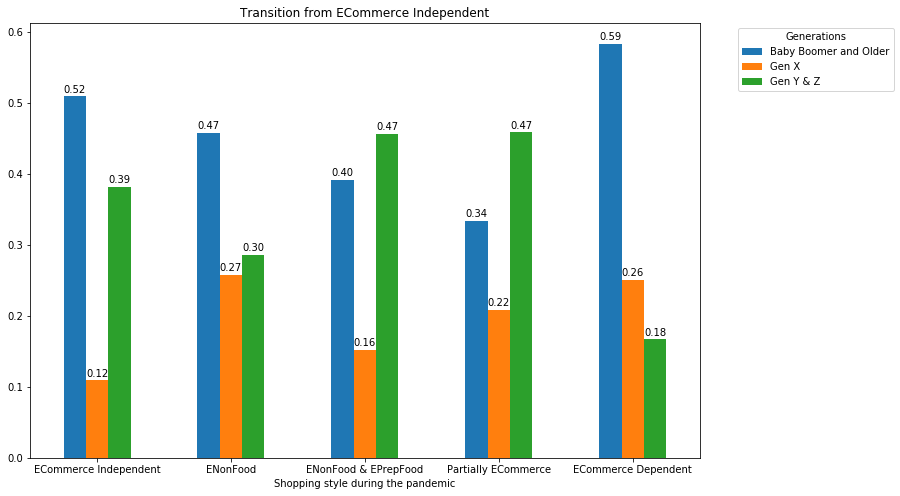

In [176]:
plt.figure(figsize = (12, 8))
sacog_demo[(sacog_demo.past_label == 'ECommerce Independent')].groupby('labels5')['ageLevel'].value_counts(normalize = True).unstack().reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent']).plot(kind = 'bar', ax = plt.gca())
plt.gca().legend(title='Generations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Transition from ECommerce Independent')
plt.xlabel('Shopping style during the pandemic')
plt.xticks(rotation = 0)

for rect in plt.gca().patches:
    # Find where everything is located
        height = rect.get_height() + 0.01
        width = rect.get_width()
        x = rect.get_x()       
        label_x = x + width/2 
 

    # plot only when height is greater than specified value
        if height > 0:
            plt.gca().text(label_x, height, f'{height:.2f}', ha='center', va='center', fontsize=10)

In [187]:
sacog_demo[sacog_demo != -9998][['Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut']].mean()

Behavior-GroceryExcuseToGetOut    3.189103
Behavior-PickupExcuseToGetOut     2.538462
NonFood-RetailExcuseToGetOut      2.945513
dtype: float64

In [192]:
sum(sacog_demo[sacog_demo != -9998]['Behavior-GroceryExcuseToGetOut'].value_counts().sort_index()[4:])/313

0.4696485623003195

In [195]:
sum(sacog_demo[sacog_demo != -9998]['NonFood-RetailExcuseToGetOut'].value_counts().sort_index()[4:])/313

0.36421725239616615

In [197]:
sacog_demo[sacog_demo != -9998].groupby('labels5')[['Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
 'NonFood-RetailExcuseToGetOut']].mean()

,Behavior-GroceryExcuseToGetOut,Behavior-PickupExcuseToGetOut,NonFood-RetailExcuseToGetOut
labels5,,,
ECommerce Dependent,3.206897,2.413793,2.793103
ECommerce Independent,3.329268,2.560976,3.048780
ENonFood,3.122807,2.263158,3.017544
ENonFood & EPrepFood,3.184783,2.826087,2.923913
Partially ECommerce,3.038462,2.365385,2.826923


In [199]:
df = sacog_demo.groupby('ageLevel')['labels5'].value_counts(normalize=True).unstack()
df[]

labels5,ECommerce Dependent,ECommerce Independent,ENonFood,ENonFood & EPrepFood,Partially ECommerce
ageLevel,,,,,
Baby Boomer and Older,0.118519,0.288889,0.207407,0.229630,0.155556
Gen X,0.092593,0.185185,0.203704,0.351852,0.166667
Gen Y & Z,0.064516,0.274194,0.145161,0.338710,0.177419


In [200]:
sacog_demo.groupby('ageLevel')['past_label'].value_counts(normalize=True).unstack()

past_label,ECommerce Dependent,ECommerce Independent,ENonFood,ENonFood & EPrepFood,Partially ECommerce
ageLevel,,,,,
Baby Boomer and Older,0.051852,0.570370,0.214815,0.096296,0.066667
Gen X,0.037037,0.555556,0.222222,0.111111,0.074074
Gen Y & Z,0.080645,0.524194,0.153226,0.129032,0.112903


In [203]:
sacog_demo[sacog_demo != -9998].groupby('ageLevel')['Behavior-GroceryExcuseToGetOut'].mean()

ageLevel
Baby Boomer and Older    3.251852
Gen X                    3.148148
Gen Y & Z                3.138211
Name: Behavior-GroceryExcuseToGetOut, dtype: float64

In [205]:
sacog_demo[sacog_demo != -9998].groupby('ageLevel')['NonFood-RetailExcuseToGetOut'].mean()

ageLevel
Baby Boomer and Older    2.785185
Gen X                    3.148148
Gen Y & Z                3.032520
Name: NonFood-RetailExcuseToGetOut, dtype: float64

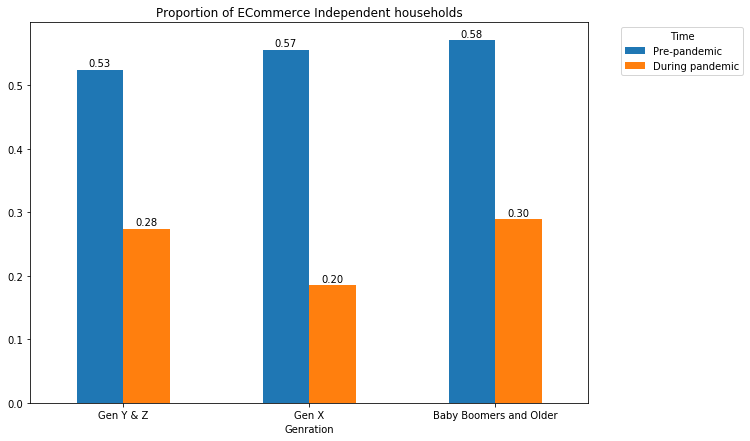

In [221]:
df = pd.DataFrame({'Pre-pandemic': [0.524194, 0.555556, 0.570370],
    'During pandemic': [0.274194, 0.185185, 0.288889]
})
df = df.rename({2:'Baby Boomers and Older', 1:'Gen X',0:'Gen Y & Z'}, axis = 0)
plt.figure(figsize=(10, 7))
df.plot(kind = 'bar', ax = plt.gca())
plt.gca().legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Proportion of ECommerce Independent households')
plt.xlabel('Genration')
plt.xticks(rotation = 0)

for rect in plt.gca().patches:
    # Find where everything is located
        height = rect.get_height() + 0.01
        width = rect.get_width()
        x = rect.get_x()       
        label_x = x + width/2 
 

    # plot only when height is greater than specified value
        if height > 0:
            plt.gca().text(label_x, height, f'{height:.2f}', ha='center', va='center', fontsize=10)

In [258]:
sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]].

,May-Portion-EChildcareItems,May-Portion-EClothing,May-Portion-EMedication,May-Portion-EHomeOffice,May-Portion-EPreparedFood,May-Portion-EOtherFood,May-Portion-EPaperCleaning,May-Portion-EGroceries
count,61.000000,237.000000,226.000000,173.000000,262.000000,163.000000,261.000000,306.000000
mean,0.603570,0.528648,0.398458,0.449491,0.379483,0.286784,0.237002,0.171528
std,0.376244,0.376877,0.379131,0.385008,0.323220,0.390355,0.332885,0.273674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.666667,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000
75%,1.000000,0.923077,0.666667,0.800000,0.600000,0.500000,0.500000,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [259]:
list(sacog_demo.columns)

['match_id',
 'PersonalIncome',
 'Children-12To18',
 'Children-5To12',
 'Children-Under5',
 'age',
 'May-Employment',
 'May-Employment-Industry',
 'HouseholdIncome',
 'Gender',
 'ethnicity_afam',
 'ethnicity_aiak',
 'ethnicity_asian',
 'ethnicity_hapi',
 'ethnicity_hisp',
 'ethnicity_mideast',
 'ethnicity_multi',
 'ethnicity_noanswer',
 'ethnicity_other',
 'ethnicity_white',
 'Disability-Chronic',
 'Disability-Developmental',
 'Disability-Hearing',
 'Disability-MentalHealth',
 'Disability-None',
 'Disability-Other',
 'Disability-Physical',
 'Disability-Vision',
 'hhveh',
 'numkids',
 'id',
 'Duration (in seconds)',
 'Response ID',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistanc

In [264]:
sacog_demo.to_csv('../data/manipulatedData/sacog_with_demo_and_preduringlabels.csv')